#Image Classification of Radio Signals using data from SETI 

##Introduction

The SETI (Search for Extraterrestrial Intelligence) Institute is a non-profit research organization, dedicated to studying life in the universe. SETI conducts experiments using radio telescope observations. One approach uses radio telescopes to listen for narrow-bandwidth radio signals from space, due to the fact that such signals are not known to occur naturally.


Radio signals can be converted into spectrograms, converting a signal classification problem into an image classification task. In this project, spectrogram image data will be used to train a custom neural network capable of classifying this type of observations. Furthermore, some transfer learning models will be implemented for the same purpose.

##Information about this dataset

This dataset contains 7000 images of seven classes.

 The radio signal classes are as follows. 

*   Bright pixel
*   Narrowband
*   Narrowbanddrd (narrowband with curvature)
*   Noise
*   Squarepulsednarrowband (narrowband with square wave amplitude modulation)
*   Squiggle 
*   Squigglesquarepulsednarrowband (squiggle with square wave amplitude
modulation)


##Imports

In [1]:
import matplotlib.pyplot as plt
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split
import sklearn
from time import time
import os
import cv2
import numpy as np
import random
%matplotlib inline
from google.colab import drive, files
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

##Loading, Visualizing and Splitting Data

In [2]:
! pip install -q kaggle

In [3]:
files.upload() #upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ellievak","key":"77078e5149ad89b552c9ad480d4e1620"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download 'tentotheminus9/seti-data'
! mkdir seti
! unzip seti-data.zip  -d seti
! rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: seti/primary_small_v3/primary_small_v3/4a1f619c-c3d4-4410-8960-f95a08acb9fc.dat  
  inflating: seti/primary_small_v3/primary_small_v3/4a228d48-fa7e-4acf-b4eb-5e6acdc86b5e.dat  
  inflating: seti/primary_small_v3/primary_small_v3/4a29fd87-442e-45ad-bb59-dce6279a1f80.dat  
  inflating: seti/primary_small_v3/primary_small_v3/4a2c4a5a-2ed0-439f-a4f3-c55de4c6b4c0.dat  
  inflating: seti/primary_small_v3/primary_small_v3/4a46fc04-dd9c-4a9f-9b73-8de844d50c0b.dat  
  inflating: seti/primary_small_v3/primary_small_v3/4a536bee-a0a4-4928-80ab-abf9ab0b4b74.dat  
  inflating: seti/primary_small_v3/primary_small_v3/4a56c8d9-9347-4cc2-83bd-74cfb556c351.dat  
  inflating: seti/primary_small_v3/primary_small_v3/4a63cd37-882d-4cf0-ac6b-e4b703acf780.dat  
  inflating: seti/primary_small_v3/primary_small_v3/4a6d3b8f-2181-479c-8de2-75dce14c91c1.dat  
  inflating: seti/primary_small_v3/primary_small_v3/4a77d659-a957-44c7-a8bd-781f676802c1.dat  

In [6]:
ls

kaggle.json  sample_data/  seti/


In [7]:
train_dir = '/content/seti/primary_small/train'
test_dir = '/content/seti/primary_small/test'
val_dir = '/content/seti/primary_small/valid'

In [8]:
classes = ['brightpixel', 'narrowband', 'narrowbanddrd', 'noise', 'squarepulsednarrowband', 'squiggle', 'squigglesquarepulsednarrowband']

brightpixel_train_img = [im for im in os.listdir('seti/primary_small/train/brightpixel')
              if any(im.endswith(ext) for ext in ['jpg','png'])]
narrowband_train_img = [im for im in os.listdir('seti/primary_small/train/narrowband')
              if any(im.endswith(ext) for ext in ['jpg','png'])]
narrowbanddrd_train_img = [im for im in os.listdir('seti/primary_small/train/narrowbanddrd')
              if any(im.endswith(ext) for ext in ['jpg','png'])]
noise_train_img = [im for im in os.listdir('seti/primary_small/train/noise')
              if any(im.endswith(ext) for ext in ['jpg','png'])]
squarepulsednarrowband_train_img = [im for im in os.listdir('seti/primary_small/train/squarepulsednarrowband')
              if any(im.endswith(ext) for ext in ['jpg','png'])]
squiggle_train_img = [im for im in os.listdir('seti/primary_small/train/squiggle')
              if any(im.endswith(ext) for ext in ['jpg','png'])]
squigglesquarepulsednarrowband_train_img = [im for im in os.listdir('seti/primary_small/train/squigglesquarepulsednarrowband')
              if any(im.endswith(ext) for ext in ['jpg','png'])]

In [9]:
print(f'There are:\n {len(brightpixel_train_img)} brightpixel images in the training set \n {len(narrowband_train_img)} narrowband images in the training set \n {len(narrowbanddrd_train_img)} narrowbanddrd images in the training set \n {len(noise_train_img)} noise images in the training set \n {len(squarepulsednarrowband_train_img)} squarepulsednarrowband images in the training set \n {len(squiggle_train_img)} squiggle images in the training set \n {len(squigglesquarepulsednarrowband_train_img)} squigglesquarepulsednarrowband images in the training set')

There are:
 800 brightpixel images in the training set 
 800 narrowband images in the training set 
 800 narrowbanddrd images in the training set 
 800 noise images in the training set 
 800 squarepulsednarrowband images in the training set 
 800 squiggle images in the training set 
 800 squigglesquarepulsednarrowband images in the training set


TypeError: ignored

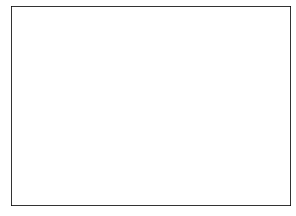

In [45]:
plt.figure(figsize=(11,30))
for i in range (0,14):
    j = random.randint(0, 799)
    plt.subplot(7,2,i+1)
    plt.xticks([])
    plt.yticks([])
    if i < 2:
       path = train_dir + "/" + classes[0] + "/" + brightpixel_train_img[j]
       img = plt.imread(path)
       plt.imshow(img)
       plt.xlabel(f'{classes[0]}, {j}')
    elif i < 4:
       path = train_dir + "/" + classes[1] + "/" + narrowband_train_img[j]
       img = plt.imread(path)
       plt.imshow(img)
       plt.xlabel(f'{classes[1]}, {j}')
    elif i < 6:
       path = train_dir + "/" + classes[2] + "/" + narrowbanddrd_train_img[j]
       img = plt.imread(path)
       plt.imshow(img)
       plt.xlabel(f'{classes[2]}, {j}')
    elif i < 8:
       path = train_dir + "/" + classes[3] + "/" + noise_train_img[j]
       img = plt.imread(path)
       plt.imshow(img)
       plt.xlabel(f'{classes[3]}, {j}')
    elif i < 10:
       path = train_dir + "/" + classes[4] + "/" + squarepulsednarrowband_train_img[j]
       img = plt.imread(path)
       plt.imshow(img)
       plt.xlabel(f'{classes[4]}, {j}')
    elif i < 12:
       path = train_dir + "/" + classes[5] + "/" + squiggle_train_img[j]
       img = plt.imread(path)
       plt.imshow(img)
       plt.xlabel(f'{classes[5]}, {j}')  
    else:
       path = train_dir + "/" + classes[6] + "/" + squigglesquarepulsednarrowband_train_img[j]
       img = plt.imread(path)
       plt.imshow(img)
       plt.xlabel(f'{classes[6]}, {j}')

In [11]:
def load_data(dir):
    images = []
    labels = []
    size = 128,128
    index = -1
    for folder in os.listdir(dir):
        index +=1
        for image in os.listdir(dir + "/" + folder):
          temp_img = cv2.imread(dir + "/" + folder + "/" + image)
          temp_img = cv2.resize(temp_img, size)
          images.append(temp_img)
          labels.append(index)
    images = np.array(images)

    images = images.astype('float32')/255.0
    labels = utils.to_categorical(labels)

    x = images
    y = labels
    
    if dir==train_dir:
      print('Loaded', len(x),'images for training,', 'Train data shape =', x.shape)
    elif dir==test_dir:
      print('Loaded', len(x),'images for testing,', 'Test data shape =', x.shape)
    else:
      print('Loaded', len(x),'images for validation,', 'Validation data shape =', x.shape)

    return x , y

In [12]:
x_train, y_train = load_data(train_dir)
x_test , y_test = load_data(test_dir)
x_val, y_val = load_data(val_dir)

Loaded 5600 images for training, Train data shape = (5600, 128, 128, 3)
Loaded 700 images for testing, Test data shape = (700, 128, 128, 3)
Loaded 700 images for validation, Validation data shape = (700, 128, 128, 3)


##Custom Convolutional Neural Network (CNN) Architecture 

In [13]:
classes = 7
batch = 90
epochs = 100 

In [14]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (128,128,3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'valid'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'valid'))
model.add(Dropout(0.2))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'valid'))
model.add(Dropout(0.2))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'valid'))
model.add(Dropout(0.2))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'valid'))
model.add(Dropout(0.2))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'valid'))
model.add(Dropout(0.2))

model.add(Conv2D(512 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 256 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(classes, activation = 'softmax'))


In [15]:
adam = Adam(learning_rate=0.0001)
save_model = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=2)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=batch, epochs=epochs, validation_data=(x_val, y_val), shuffle = True, verbose=1, 
                    callbacks=[save_model])

Epoch 1/100
63/63 [==============================] - ETA: 0s - loss: 2.0794 - accuracy: 0.2161
Epoch 1: val_loss improved from inf to 1.94945, saving model to best_model.h5
63/63 [==============================] - 18s 114ms/step - loss: 2.0794 - accuracy: 0.2161 - val_loss: 1.9494 - val_accuracy: 0.1429
Epoch 2/100
62/63 [============================>.] - ETA: 0s - loss: 1.8553 - accuracy: 0.2588
Epoch 2: val_loss did not improve from 1.94945
63/63 [==============================] - 5s 79ms/step - loss: 1.8550 - accuracy: 0.2589 - val_loss: 1.9681 - val_accuracy: 0.1443
Epoch 3/100
62/63 [============================>.] - ETA: 0s - loss: 1.7857 - accuracy: 0.2789
Epoch 3: val_loss did not improve from 1.94945
63/63 [==============================] - 5s 79ms/step - loss: 1.7851 - accuracy: 0.2795 - val_loss: 2.0327 - val_accuracy: 0.1429
Epoch 4/100
62/63 [============================>.] - ETA: 0s - loss: 1.7201 - accuracy: 0.3048
Epoch 4: val_loss did not improve from 1.94945
63/63 [==

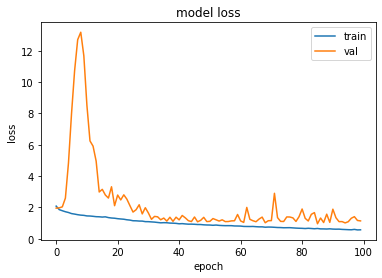

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

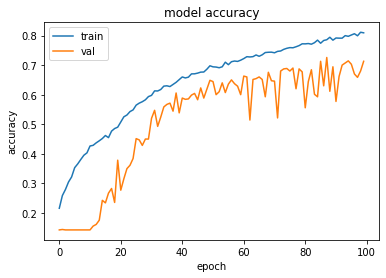

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
history.model.load_weights('best_model.h5')
np.mean(np.argmax(history.model.predict(x_test),1)==np.argmax(y_test,1))

22/22 [==============================] - 1s 22ms/step


0.7

In [19]:
np.mean(np.argmax(history.model.predict(x_train),1)==np.argmax(y_train,1))

175/175 [==============================] - 1s 8ms/step


0.7910714285714285

In [33]:
y_pred = model.predict(x_test) 
y_classes = y_pred.argmax(axis=1)
y_true = y_test.argmax(axis=1)
print(sklearn.metrics.confusion_matrix(y_true, y_classes, labels=None))

22/22 [==============================] - 0s 10ms/step
[[42 30  3  7  0 15  3]
 [ 4 82  6  0  0  5  3]
 [ 3 12 53  1  5 11 15]
 [ 5  8  1 80  1  2  3]
 [ 0  1  5 10 62 10 12]
 [ 0  0  0  0  1 92  7]
 [ 0  0  0  0  0 21 79]]


In [34]:
print(classification_report(y_true, y_classes))

              precision    recall  f1-score   support

           0       0.78      0.42      0.55       100
           1       0.62      0.82      0.70       100
           2       0.78      0.53      0.63       100
           3       0.82      0.80      0.81       100
           4       0.90      0.62      0.73       100
           5       0.59      0.92      0.72       100
           6       0.65      0.79      0.71       100

    accuracy                           0.70       700
   macro avg       0.73      0.70      0.69       700
weighted avg       0.73      0.70      0.69       700



##Transfer Learning

###VGG16

In [42]:
classes = 7
batch = 90 
epochs = 30

In [43]:
VGG16_model = VGG16(
    weights='imagenet',
    input_shape=(128, 128, 3),
    include_top=False) 

VGG16_model.trainable = False


inputs = keras.Input(shape=(128, 128, 3))

x = VGG16_model(inputs, training=False)

x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)

outputs = keras.layers.Dense(classes, activation = 'softmax')(x)

model = keras.Model(inputs,outputs)

58889256/58889256 [==============================] - 1s 0us/step


In [44]:
adam = Adam(learning_rate=0.0001)
save_model = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=2)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=batch, epochs=epochs, validation_data=(x_val, y_val), shuffle = True, verbose=1, 
                    callbacks=[save_model])

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 1.7254 - accuracy: 0.3375
Epoch 1: val_loss improved from inf to 1.92978, saving model to best_model.h5
63/63 [==============================] - 18s 216ms/step - loss: 1.7254 - accuracy: 0.3375 - val_loss: 1.9298 - val_accuracy: 0.1457
Epoch 2/30
62/63 [============================>.] - ETA: 0s - loss: 1.4852 - accuracy: 0.4369
Epoch 2: val_loss improved from 1.92978 to 1.89853, saving model to best_model.h5
63/63 [==============================] - 10s 157ms/step - loss: 1.4854 - accuracy: 0.4363 - val_loss: 1.8985 - val_accuracy: 0.1557
Epoch 3/30
62/63 [============================>.] - ETA: 0s - loss: 1.3993 - accuracy: 0.4620
Epoch 3: val_loss improved from 1.89853 to 1.86425, saving model to best_model.h5
63/63 [==============================] - 10s 159ms/step - loss: 1.3994 - accuracy: 0.4616 - val_loss: 1.8642 - val_accuracy: 0.1600
Epoch 4/30
62/63 [============================>.] - ETA: 0s - loss: 1.3508 - acc

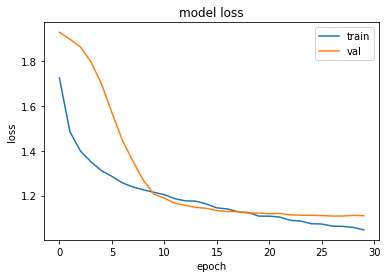

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

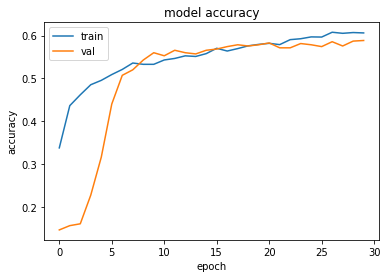

In [46]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [47]:
history.model.load_weights('best_model.h5')
np.mean(np.argmax(history.model.predict(x_test),1)==np.argmax(y_test,1))

22/22 [==============================] - 4s 113ms/step


0.5685714285714286

In [48]:
np.mean(np.argmax(history.model.predict(x_val),1)==np.argmax(y_val,1))

22/22 [==============================] - 1s 51ms/step


0.5757142857142857

###ResNet50

In [30]:
classes = 7
batch = 90 
epochs = 70

In [39]:
resnet50_model = ResNet50(
    weights='imagenet', 
    input_shape=(128,128, 3),
    include_top=False)

resnet50_model.trainable =  False

inputs = keras.Input(shape=(128,128, 3))

x = resnet50_model(inputs, training=False)

x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(classes, activation = 'softmax')(x)

resnet50_model = keras.Model(inputs,outputs)

In [40]:
adam = Adam(learning_rate=0.0001)
save_model = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=2)
resnet50_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = resnet50_model.fit(x_train, y_train, batch_size=batch, epochs=epochs, validation_data=(x_val,y_val), shuffle = True, verbose=1, callbacks=[save_model])

Epoch 1/70
62/63 [============================>.] - ETA: 0s - loss: 1.8786 - accuracy: 0.2423
Epoch 1: val_loss improved from inf to 2.59671, saving model to best_model.h5
63/63 [==============================] - 12s 135ms/step - loss: 1.8789 - accuracy: 0.2418 - val_loss: 2.5967 - val_accuracy: 0.1429
Epoch 2/70
62/63 [============================>.] - ETA: 0s - loss: 1.7450 - accuracy: 0.2939
Epoch 2: val_loss improved from 2.59671 to 1.98173, saving model to best_model.h5
63/63 [==============================] - 7s 118ms/step - loss: 1.7448 - accuracy: 0.2943 - val_loss: 1.9817 - val_accuracy: 0.1429
Epoch 3/70
62/63 [============================>.] - ETA: 0s - loss: 1.6838 - accuracy: 0.3247
Epoch 3: val_loss improved from 1.98173 to 1.96253, saving model to best_model.h5
63/63 [==============================] - 8s 120ms/step - loss: 1.6844 - accuracy: 0.3243 - val_loss: 1.9625 - val_accuracy: 0.1786
Epoch 4/70
62/63 [============================>.] - ETA: 0s - loss: 1.6522 - accur

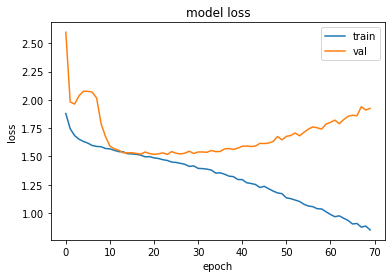

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

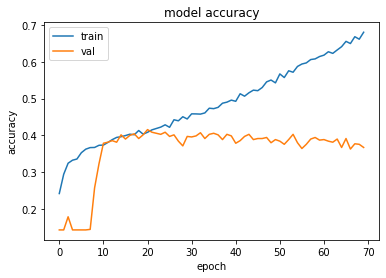

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [43]:
history.model.load_weights('best_model.h5')
np.mean(np.argmax(history.model.predict(x_test),1)==np.argmax(y_test,1))

22/22 [==============================] - 2s 42ms/step


0.37714285714285717

In [44]:
np.mean(np.argmax(history.model.predict(x_train),1)==np.argmax(y_train,1))

175/175 [==============================] - 7s 39ms/step


0.44607142857142856

This is a case of overfitting, as we can see in the plots above, the training accuracy increases while validation accuracy reaches its peak and then decreases. On the contrary, while training loss plummets, validation loss increases.

##Conclusion

Due to the big number of data, the need for automated classification has risen, which brings Deep Learning into the picture. In this project, a custom CNN model and some transfer learning models have been used for classifying spectrograms. Comparing their performance we can conclude that the custom architecture was the most effective, with approximately 70% accuracy. 

Generally, neural networks are capable of classifying spectrograms both time efficiently and effectively. In conclusion, AI can contribute massively to deep space research and consequently help in expanding our understanding about abnormal radio signals received from space. 